# Exercise on Ridge and Lasso Regression
The purpose of this exercise is to display the effects of and applications of **regularization methodologies**.

### Part 1 - Data Generation and Dataset Splitting

Let us assume we are working with noisy data for a wind power curve, consisting of both wind speed and wind power measurements. Especially when the dataset is limited, it is not possible to fully capture the true underlying mapping function during training. However, our goal is to achieve the **best possible accuracy** by applying **regularization techniques**.

For proper model development, we need three datasets:
- **Training set**: Used to fit model parameters (coefficients)
- **Validation set**: Used to tune hyperparameters (regularization strength, polynomial degree)
- **Test set**: Used only for final performance evaluation

The **training set** and **validation set** will contain noisy measurements from a wind turbine power curve, while the **test set** will represent a perfect power curve without noise.

#### Task:
Simply run this cell to get your train/validation/test splits (x_train, x_val, x_test, y_train, y_val, y_test).

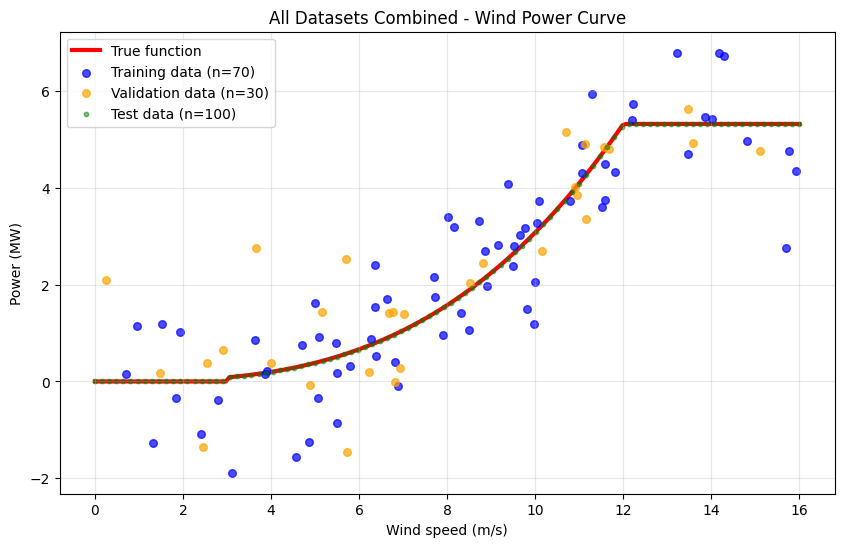

Training set size: 70 points
Validation set size: 30 points
Test set size: 100 points
Total training data split: 70/30 = 70%/30% (train/validation)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(123)

def complex_function(x):
    """
    Wind turbine power curve, x is the wind speed.
    Accepts a scalar or a numpy array of x values.
    """
    rho = 1.225  # Air density (kg/m^3)
    r = 40  # Rotor radius (m)
    A = np.pi * r**2  # Swept area (m^2)

    cut_in = 3  # Cut-in wind speed (m/s)
    rated = 12  # Rated wind speed (m/s)
    cut_out = 25  # Cut-out wind speed (m/s)

    x = np.asarray(x)
    result = np.zeros_like(x, dtype=float)
    # Below cut-in or above cut-out
    mask_0 = (x < cut_in) | (x >= cut_out)
    # Between rated and cut-out
    mask_rated = (x >= rated) & (x < cut_out)
    # Between cut-in and rated
    mask_cutin_rated = (x >= cut_in) & (x < rated)

    result[mask_rated] = 0.5 * rho * A * (rated**3) / 1e6
    result[mask_cutin_rated] = 0.5 * rho * A * (x[mask_cutin_rated]**3) / 1e6
    # result[mask_0] is already zero
    return result if result.shape != () else float(result)

# Parameters
train_val_points = 100  
test_points = 100 
noise_level = 1 
x_range_train = (0, 16)  # Train data domain
x_range_test = (0, 16)   # Test data domain

# Generate initial training data (will be split into train/validation)
x_train_initial = np.random.uniform(x_range_train[0], x_range_train[1], train_val_points)
x_train_initial = np.sort(x_train_initial)  # Sort for better visualization
y_train_initial = complex_function(x_train_initial) + np.random.normal(0, noise_level, train_val_points)

# Split training data into training and validation sets (70% train, 30% validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_initial, y_train_initial, test_size=0.3, random_state=42
)

# Generate test data (larger, evenly spaced sample, no noise)
x_test = np.linspace(x_range_test[0], x_range_test[1], test_points)
y_test = complex_function(x_test) + np.random.normal(0, 0, test_points)

# Plot all three datasets together in one plot
plt.figure(figsize=(10, 6))

# Plot all datasets together
x_smooth = np.linspace(x_range_train[0], x_range_train[1], 200)
plt.plot(x_smooth, complex_function(x_smooth), color='red', label='True function', linewidth=3, zorder =0)
plt.scatter(x_train, y_train, color='blue', alpha=0.7, label=f'Training data (n={len(x_train)})', s=30)
plt.scatter(x_val, y_val, color='orange', alpha=0.7, label=f'Validation data (n={len(x_val)})', s=30)
plt.scatter(x_test, y_test, color='green', alpha=0.5, label=f'Test data (n={len(x_test)})', s=10)
plt.legend()
plt.title('All Datasets Combined - Wind Power Curve')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training set size: {len(x_train)} points")
print(f"Validation set size: {len(x_val)} points") 
print(f"Test set size: {len(x_test)} points")
print(f"Total training data split: {len(x_train)}/{len(x_val)} = {len(x_train)/(len(x_train)+len(x_val))*100:.0f}%/{len(x_val)/(len(x_train)+len(x_val))*100:.0f}% (train/validation)")

### Part 2 - Basic Polynomial Regression 
On top of the generated data, fit a **12th degree polynomial** using only the **training set**.   
You can consider creating a polynomial feature class: https://sklearn.vercel.app/docs/classes/PolynomialFeatures   
And use the built in "fit_transform" of the class on your **training data** to make polynomial training data. This is also shown in the PolynomialFeatures documentation.

#### Task:
Fit a 12th degree polynomial on the training set and predict based on the test set, visualize the results and notice any signs of overfitting. Note the test error for comparison.

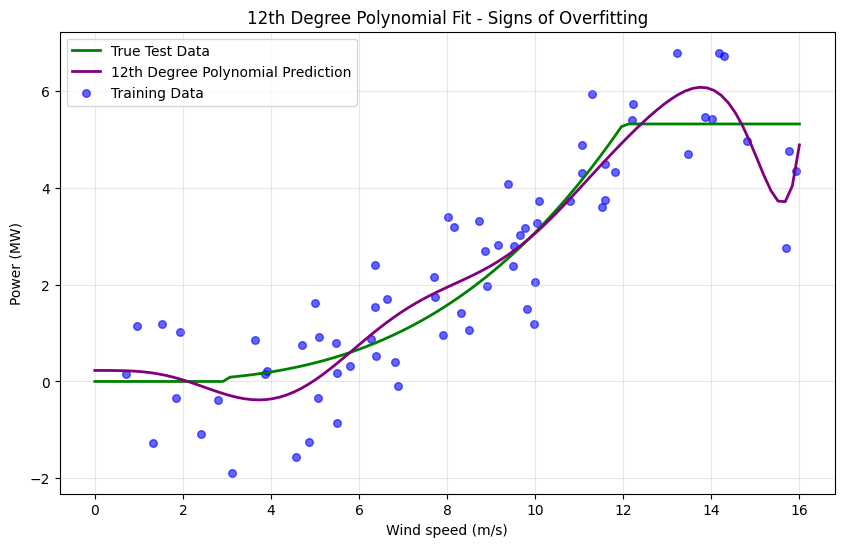

Test MSE (12th degree polynomial): 0.2107


In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create polynomial features (degree 12)
poly = PolynomialFeatures(degree=12)
X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
X_test_poly = poly.transform(x_test.reshape(-1, 1))

# Fit linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on test set
y_test_pred = model.predict(X_test_poly)

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='green', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred, color='purple', label='12th Degree Polynomial Prediction', linewidth=2)
plt.scatter(x_train, y_train, color='blue', alpha=0.6, label='Training Data', s=30)
plt.title('12th Degree Polynomial Fit - Signs of Overfitting')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print test error
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE (12th degree polynomial): {test_mse:.4f}")

### Part 3 - Hyperparameter Tuning with Validation Set

Now let's use the **validation set** to find the **optimal polynomial degree**. This demonstrates the proper workflow: **train** on training set, **tune** on validation set, **evaluate** on test set. 

#### Task:
Try fitting different degrees of polynomials on the training set and visualize the results. To decide the optimal degree, you should pick the one with the lowest validation set error. Calculate the test set error based on the polynomial of optimal degree and compare with 12th degree polynomial.

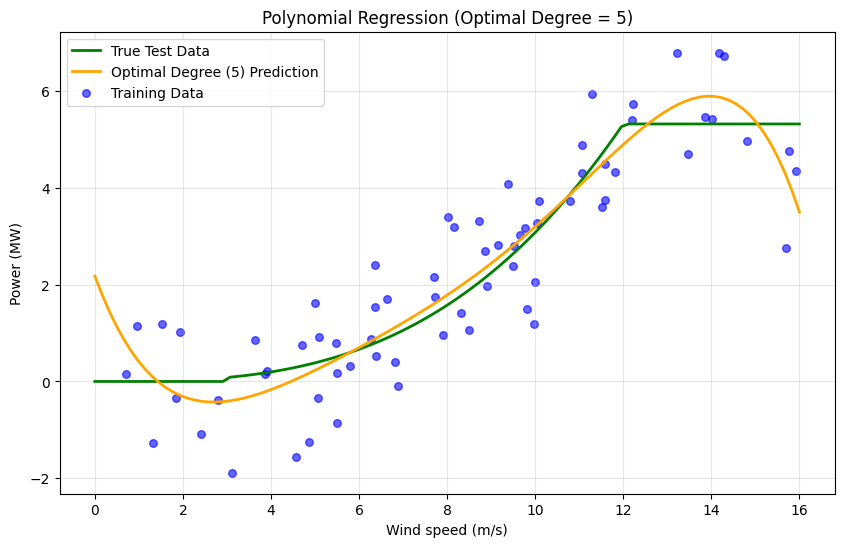

Optimal polynomial degree (lowest validation error): 5
Test MSE (optimal degree): 0.2677
Test MSE (12th degree): 0.2107


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees = range(1, 16)
val_errors = []
test_errors = []

for d in degrees:
    poly_d = PolynomialFeatures(degree=d)
    X_train_poly = poly_d.fit_transform(x_train.reshape(-1, 1))
    X_val_poly = poly_d.transform(x_val.reshape(-1, 1))
    X_test_poly = poly_d.transform(x_test.reshape(-1, 1))
    
    model_d = LinearRegression()
    model_d.fit(X_train_poly, y_train)
    
    y_val_pred = model_d.predict(X_val_poly)
    y_test_pred = model_d.predict(X_test_poly)
    
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

optimal_degree = degrees[val_errors.index(min(val_errors))]

# Fit and plot with optimal degree
poly_opt = PolynomialFeatures(degree=optimal_degree)
X_train_poly_opt = poly_opt.fit_transform(x_train.reshape(-1, 1))
X_test_poly_opt = poly_opt.transform(x_test.reshape(-1, 1))
model_opt = LinearRegression()
model_opt.fit(X_train_poly_opt, y_train)
y_test_pred_opt = model_opt.predict(X_test_poly_opt)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='green', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred_opt, color='orange', label=f'Optimal Degree ({optimal_degree}) Prediction', linewidth=2)
plt.scatter(x_train, y_train, color='blue', alpha=0.6, label='Training Data', s=30)
plt.title(f'Polynomial Regression (Optimal Degree = {optimal_degree})')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal polynomial degree (lowest validation error): {optimal_degree}")
print(f"Test MSE (optimal degree): {test_errors[optimal_degree-1]:.4f}")
print(f"Test MSE (12th degree): {test_mse:.4f}")

### Part 4 - Lasso Regression (L1 Regularization)

Lasso Regression performs both **regularization** and **feature selection**. It introduces an **L1 regularization** penalty to the model, which adds the absolute value of the coefficients to the loss function. The optimization problem for Lasso regression can be formulated as:

$$
\text{Minimize} \left( \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right)
$$

where:
- $y_i$ is the true value of the target variable,
- $\hat{y}_i$ is the predicted value by the model,
- $\beta_j$ is the coefficient for the \( j \)-th feature,
- $\alpha$ is the **regularization parameter**. It controls the strength of the regularization.

**Key Feature of Lasso**: Unlike Ridge regression, Lasso can shrink some coefficients to **exactly zero**, effectively selecting a subset of features that contribute the most to the prediction. This automatic feature selection makes Lasso regression ideal for models with many predictors, where it is essential to simplify the model and remove irrelevant or redundant features.   

You do not need to implement the optimization, you can use the sklearn "Lasso" function. Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso   
Try using different values for **alpha**, and consider how it changes the model. A **higher alpha** results in more aggressive regularization and **more coefficients set to zero**.

We'll evaluate on **training**, **validation**, and **test** sets to see the full picture.   
NOTE: the alpha parameter does not have to be between 0 and 1. It applies an error term that is dependent on the coefficients, so if the polynomial coefficients are very small, alpha might need to be very large to make a difference.

#### Task: 
Perform lasso regularization on a 12th degree polynomial, find the optimal alpha based on the validation set error and visualize the results. Compare test error with the unregularized 12th degree polynomial. 

/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+01, tolerance: 3.313e-02
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e+01, tolerance: 3.313e-02
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to inc

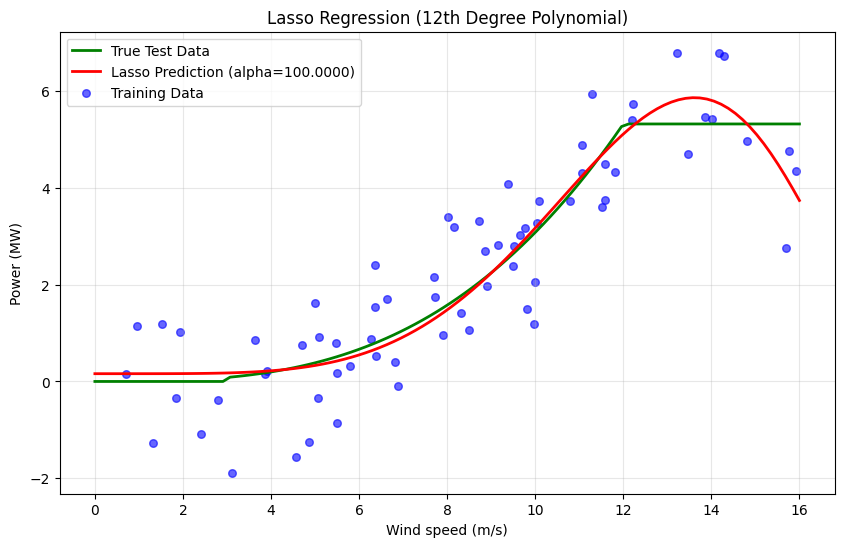

Optimal alpha (lowest validation error): 100.0000
Test MSE (Lasso, optimal alpha): 0.0956
Test MSE (unregularized 12th degree): 0.2107


In [6]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, 2, 30)
val_errors_lasso = []
test_errors_lasso = []
train_errors_lasso = []

X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
X_val_poly = poly.transform(x_val.reshape(-1, 1))
X_test_poly = poly.transform(x_test.reshape(-1, 1))

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_poly, y_train)
    y_val_pred = lasso.predict(X_val_poly)
    y_test_pred = lasso.predict(X_test_poly)
    y_train_pred = lasso.predict(X_train_poly)
    val_errors_lasso.append(mean_squared_error(y_val, y_val_pred))
    test_errors_lasso.append(mean_squared_error(y_test, y_test_pred))
    train_errors_lasso.append(mean_squared_error(y_train, y_train_pred))

optimal_alpha = alphas[np.argmin(val_errors_lasso)]

# Fit Lasso with optimal alpha
lasso_opt = Lasso(alpha=optimal_alpha, max_iter=10000)
lasso_opt.fit(X_train_poly, y_train)
y_test_pred_lasso = lasso_opt.predict(X_test_poly)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='green', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred_lasso, color='red', label=f'Lasso Prediction (alpha={optimal_alpha:.4f})', linewidth=2)
plt.scatter(x_train, y_train, color='blue', alpha=0.6, label='Training Data', s=30)
plt.title('Lasso Regression (12th Degree Polynomial)')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal alpha (lowest validation error): {optimal_alpha:.4f}")
print(f"Test MSE (Lasso, optimal alpha): {min(test_errors_lasso):.4f}")
print(f"Test MSE (unregularized 12th degree): {test_mse:.4f}")

### Part 5 - Ridge Regression (L2 Regularization)

Adding a **penalty term**, called **L2 regularization**, to handle **multicollinearity** and reduce **overfitting**. This shrinks the magnitude of the model coefficients. The objective is to minimize the **residual sum of squares** while also penalizing **large coefficients**. The optimization problem for Ridge regression can be formulated as:

$$
\text{Minimize} \left( \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2 \right)
$$

where:
- $y_i$ is the true value of the target variable,
- $ \hat{y}_i$ is the predicted value by the model,
- $\beta_j$ is the coefficient for the $j$-th feature,
- $\alpha$ is the **regularization parameter**. It controls the strength of the regularization.

Ridge regression is particularly useful when there are many **correlated features** in the dataset, as it helps **stabilize** the coefficient estimates and improve **model generalization**. Unlike Lasso, Ridge regression does **not eliminate any features**, but it shrinks the impact of less relevant ones, reducing model complexity while **preserving all variables** in the model.   
You also do not need to implement the optimization problem for this, you may use the Ridge function: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge   
A **higher alpha** gives **stronger regularization**.

We'll evaluate on **training**, **validation**, and **test** sets to compare with the other methods.   
NOTE: the alpha parameter does not have to be between 0 and 1. It applies an error term that is dependent on the coefficients, so if the polynomial coefficients are very small, alpha might need to be very large to make a difference.

#### Task:
Perform ridge regularization on a 12th degree polynomial, find the optimal alpha based on the validation set error and visualize the results. Compare test error with the unregularized 12th degree polynomial.

/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.04713e-34): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.1272e-34): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.30869e-33): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.10734e-33): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jonaswiendl/local/

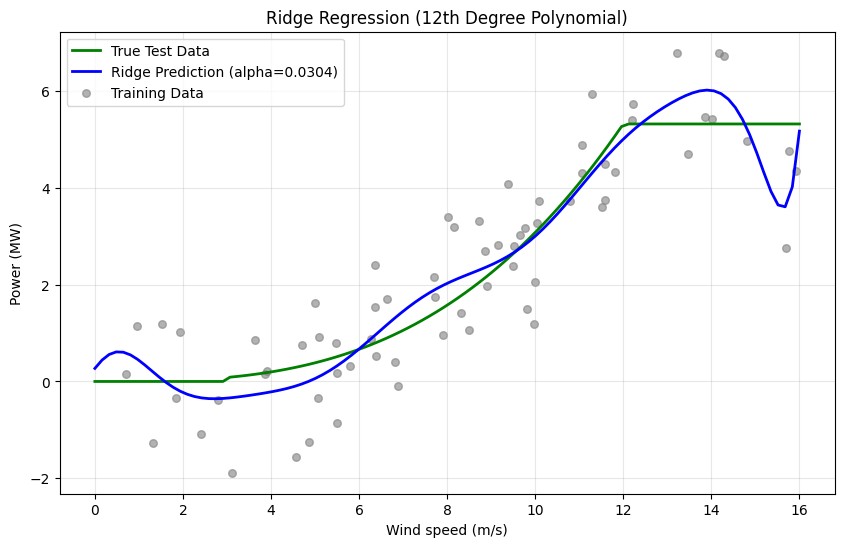

Optimal alpha (lowest validation error): 0.0304
Test MSE (Ridge, optimal alpha): 0.2107
Test MSE (unregularized 12th degree): 0.2107


In [8]:
from sklearn.linear_model import Ridge

val_errors_ridge = []
test_errors_ridge = []
train_errors_ridge = []

X_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
X_val_poly = poly.transform(x_val.reshape(-1, 1))
X_test_poly = poly.transform(x_test.reshape(-1, 1))

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_poly, y_train)
    y_val_pred = ridge.predict(X_val_poly)
    y_test_pred = ridge.predict(X_test_poly)
    y_train_pred = ridge.predict(X_train_poly)
    val_errors_ridge.append(mean_squared_error(y_val, y_val_pred))
    test_errors_ridge.append(mean_squared_error(y_test, y_test_pred))
    train_errors_ridge.append(mean_squared_error(y_train, y_train_pred))

optimal_alpha_ridge = alphas[np.argmin(val_errors_ridge)]

# Fit Ridge with optimal alpha
ridge_opt = Ridge(alpha=optimal_alpha_ridge, max_iter=10000)
ridge_opt.fit(X_train_poly, y_train)
y_test_pred_ridge = ridge_opt.predict(X_test_poly)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='green', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred_ridge, color='blue', label=f'Ridge Prediction (alpha={optimal_alpha_ridge:.4f})', linewidth=2)
plt.scatter(x_train, y_train, color='gray', alpha=0.6, label='Training Data', s=30)
plt.title('Ridge Regression (12th Degree Polynomial)')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal alpha (lowest validation error): {optimal_alpha_ridge:.4f}")
print(f"Test MSE (Ridge, optimal alpha): {min(test_errors_ridge):.4f}")
print(f"Test MSE (unregularized 12th degree): {test_mse:.4f}")

### Part 6 - Compare Models

Let's compare all three models to see how **regularization** helps reduce **overfitting** and improves **generalization** to new data. Examine performance on **training**, **validation**, and **test** sets.   
Here you can implement a script to compare the errors of the figures, or simply go back and look at the test errors. Notice how a low training error doesn't necessarily translate to a low test error

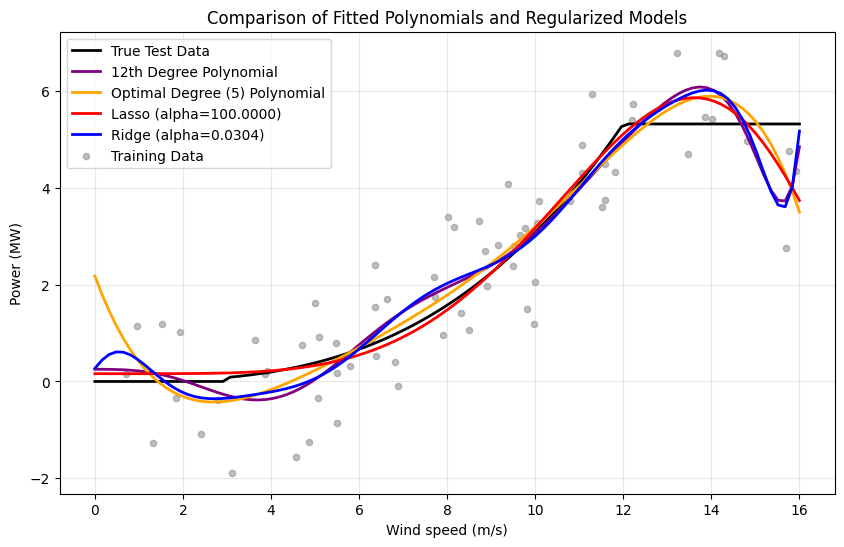

=== Model Comparison ===
Unregularized 12th degree polynomial:
  Training MSE: 0.7831
  Validation MSE: 1.1704
  Test MSE: 0.2107

Optimal polynomial degree (5):
  Test MSE: 0.2677

Lasso Regression (alpha=100.0000):
  Training MSE: 0.8749
  Validation MSE: 0.9643
  Test MSE: 0.0956

Ridge Regression (alpha=0.0304):
  Training MSE: 0.7690
  Validation MSE: 1.0911
  Test MSE: 0.2107


In [13]:
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='black', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred, color='purple', label='12th Degree Polynomial', linewidth=2)
plt.plot(x_test, y_test_pred_opt, color='orange', label=f'Optimal Degree ({optimal_degree}) Polynomial', linewidth=2)
plt.plot(x_test, y_test_pred_lasso, color='red', label=f'Lasso (alpha={optimal_alpha:.4f})', linewidth=2)
plt.plot(x_test, y_test_pred_ridge, color='blue', label=f'Ridge (alpha={optimal_alpha_ridge:.4f})', linewidth=2)
plt.scatter(x_train, y_train, color='gray', alpha=0.5, label='Training Data', s=20)
plt.title('Comparison of Fitted Polynomials and Regularized Models')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare training, validation, and test errors for all models

print("=== Model Comparison ===")
print(f"Unregularized 12th degree polynomial:")
print(f"  Training MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"  Validation MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"  Test MSE: {test_mse:.4f}\n")

print(f"Optimal polynomial degree ({optimal_degree}):")
print(f"  Test MSE: {test_errors[optimal_degree-1]:.4f}\n")

print(f"Lasso Regression (alpha={optimal_alpha:.4f}):")
print(f"  Training MSE: {train_errors_lasso[np.argmin(val_errors_lasso)]:.4f}")
print(f"  Validation MSE: {min(val_errors_lasso):.4f}")
print(f"  Test MSE: {min(test_errors_lasso):.4f}\n")

print(f"Ridge Regression (alpha={optimal_alpha_ridge:.4f}):")
print(f"  Training MSE: {train_errors_ridge[np.argmin(val_errors_ridge)]:.4f}")
print(f"  Validation MSE: {min(val_errors_ridge):.4f}")
print(f"  Test MSE: {min(test_errors_ridge):.4f}")

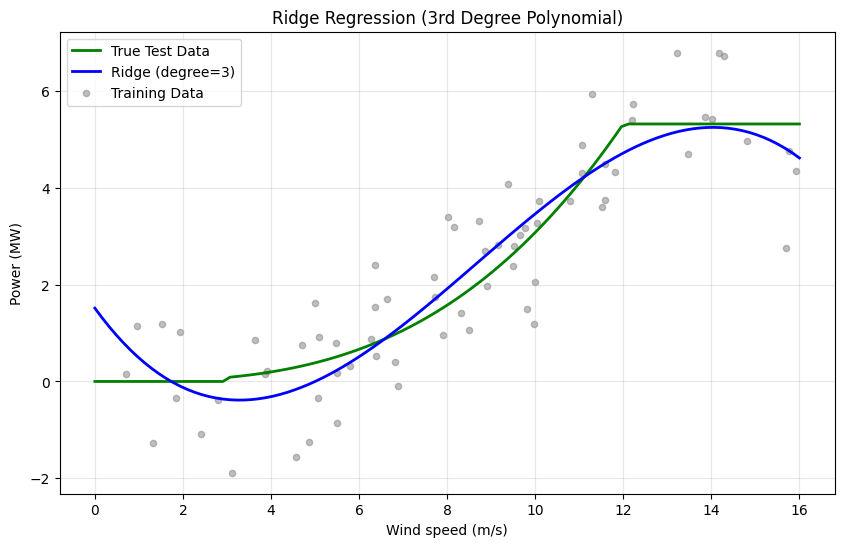

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Create polynomial features (degree 3)
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(x_train.reshape(-1, 1))
X_test_poly3 = poly3.transform(x_test.reshape(-1, 1))

# Fit Ridge regression model (L2 regularization) with alpha=optimal_alpha_ridge
ridge3 = Ridge(alpha=optimal_alpha_ridge, max_iter=10000)
ridge3.fit(X_train_poly3, y_train)

# Predict on test set
y_test_pred_ridge3 = ridge3.predict(X_test_poly3)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, color='green', label='True Test Data', linewidth=2)
plt.plot(x_test, y_test_pred_ridge3, color='blue', label='Ridge (degree=3)', linewidth=2)
plt.scatter(x_train, y_train, color='gray', alpha=0.5, label='Training Data', s=20)
plt.title('Ridge Regression (3rd Degree Polynomial)')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

# Predict on validation set for degree 3 polynomial
X_val_poly3 = poly3.transform(x_val.reshape(-1, 1))
y_val_pred_ridge3 = ridge3.predict(X_val_poly3)
train_mse_ridge3 = mean_squared_error(y_train, ridge3.predict(X_train_poly3))
val_mse_ridge3 = mean_squared_error(y_val, y_val_pred_ridge3)
test_mse_ridge3 = mean_squared_error(y_test, y_test_pred_ridge3)

print("=== Ridge Regression (degree=3) Error Metrics ===")
print(f"Training MSE: {train_mse_ridge3:.4f}")
print(f"Validation MSE: {val_mse_ridge3:.4f}")
print(f"Test MSE: {test_mse_ridge3:.4f}")

=== Ridge Regression (degree=3) Error Metrics ===
Training MSE: 0.9026
Validation MSE: 1.0059
Test MSE: 0.1807
